# Semantic Variation Study

## Functions and Libraries

In [31]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt

## BERTweet

In [32]:
# Load TweetBERT for embedding
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


## Analysis

In [49]:
def calculate_semantic_variation(data, gen_title, model, tokenizer):
  topics = data['prompt'].unique()
  variation_scores = {}

  for topic in topics:
    print(f"Processing topic: {topic}")  # Print the topic being processed
    topic_data = data[data['prompt'] == topic][gen_title].tolist()
    inputs = tokenizer(topic_data, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
      outputs = model(**inputs)
      embeddings = outputs.last_hidden_state.mean(dim=1)

    cosine_sim = torch.nn.functional.cosine_similarity
    n = embeddings.size(0)
    pairwise_similarities = [
            cosine_sim(embeddings[i], embeddings[j], dim=0).item()
            for i in range(n) for j in range(i + 1, n)
            ]

    # Calculate the Variation
    average_similarity = np.mean(pairwise_similarities)
    variation_scores[topic] = 1 - average_similarity

  return variation_scores

In [50]:
# 'human_baseline', 'Gemini', 'Phi-14B', 'Phi-Tweet'
models = [
    {
        "model": "human_baseline",
        "file": "/content/sample_data/human_tweets_baseline.csv",
        "generation_title": "human tweets"
    },{
        "model": "Gemini",
        "file": "/content/sample_data/gemini_baseline.csv",
        "generation_title": "human tweets"
    },{
        "model": "Phi-14B",
        "file": "/content/sample_data/14B_3shots_real.csv",
        "generation_title": "microsoft/Phi-3-medium-4k-instruct"
    },{
        "model": "Phi-Tweet",
        "file": "/content/sample_data/100k_3_shots_post_real.csv",
        "generation_title": "AlanYky/phi-3.5_tweets_instruct"
    }
]

results = {}

In [51]:
for model_name in models:
    print(f"Processing Model: {model_name['model']}")
    data = pd.read_csv(model_name["file"])  # Assuming a CSV format
    results[model_name["model"]] = calculate_semantic_variation(
        data,
        model_name["generation_title"],
        model,
        tokenizer,
      )
    print("----------")

Processing Model: human_baseline
Processing topic: palestinian
Processing topic: donald
Processing topic: black friday
Processing topic: Tax Break
Processing topic: Ukraine
Processing topic: NBA
Processing topic: Taylor Swift
Processing topic: Mbappe
Processing topic: curry
Processing topic: las
Processing topic: montreal
Processing topic: squid
Processing topic: halloween
Processing topic: work
Processing topic: zero
Processing topic: Trudeau
Processing topic: trump
Processing topic: ChatGPT
Processing topic: Biden
Processing topic: LeBron
Processing topic: tech
Processing topic: SpaceX
Processing topic: AI
Processing topic: iphone
Processing topic: apple
----------
Processing Model: Gemini
Processing topic: Palestinian
Processing topic: Donald Trump 2025 President
Processing topic: Black Friday 2024
Processing topic: Tax Break Canada
Processing topic: Ukraine Russia war
Processing topic: NBA Final
Processing topic: Taylor Swift 2024
Processing topic: Mbappe
Processing topic: Stephen 

In [52]:
results

{'human_baseline': {'palestinian': 0.3076130443149143,
  'donald': 0.2700937489668528,
  'black friday': 0.3394465446472168,
  'Tax Break': 0.2879902561505635,
  'Ukraine': 0.32140243947505953,
  'NBA': 0.377784808476766,
  'Taylor Swift': 0.3612773931688733,
  'Mbappe': 0.278171753221088,
  'curry': 0.3630094160636266,
  'las': 0.3146515273385577,
  'montreal': 0.261732855770323,
  'squid': 0.21200266149308944,
  'halloween': 0.2888292676872677,
  'work': 0.3310419102509816,
  'zero': 0.32033533387713964,
  'Trudeau': 0.27662461499373114,
  'trump': 0.31175270179907477,
  'ChatGPT': 0.27128927508989975,
  'Biden': 0.30520281030072105,
  'LeBron': 0.36075796816084116,
  'tech': 0.3408950060606003,
  'SpaceX': 0.3250371946228875,
  'AI': 0.27551153765784364,
  'iphone': 0.31825325588385267,
  'apple': 0.38206593592961624},
 'Gemini': {'Palestinian': 0.19715567297405667,
  'Donald Trump 2025 President': 0.05019453499052262,
  'Black Friday 2024': 0.1646307932005988,
  'Tax Break Canada':

In [53]:
# Aggregate Results
aggregate_results = {
    model: {
        "mean_variation": np.mean(list(scores.values())),
        "std_variation": np.std(list(scores.values()))
    }
    for model, scores in results.items()
}

In [54]:
aggregate_results

{'human_baseline': {'mean_variation': 0.31211093045605554,
  'std_variation': 0.039907257563699686},
 'Gemini': {'mean_variation': 0.16266253654162088,
  'std_variation': 0.05409580501842561},
 'Phi-14B': {'mean_variation': 0.14747767859035066,
  'std_variation': 0.04132526114270169},
 'Phi-Tweet': {'mean_variation': 0.21425606120957266,
  'std_variation': 0.024075582750604715}}

In [62]:
models_names = [model['model'] for model in models]
models_names

['human_baseline', 'Gemini', 'Phi-14B', 'Phi-Tweet']

                mean_variation  std_variation
human_baseline        0.312111       0.039907
Gemini                0.162663       0.054096
Phi-14B               0.147478       0.041325
Phi-Tweet             0.214256       0.024076


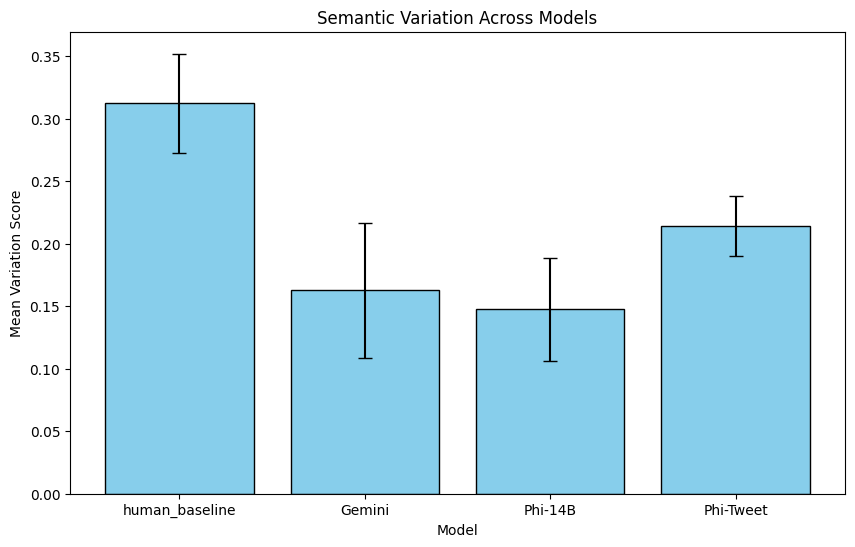

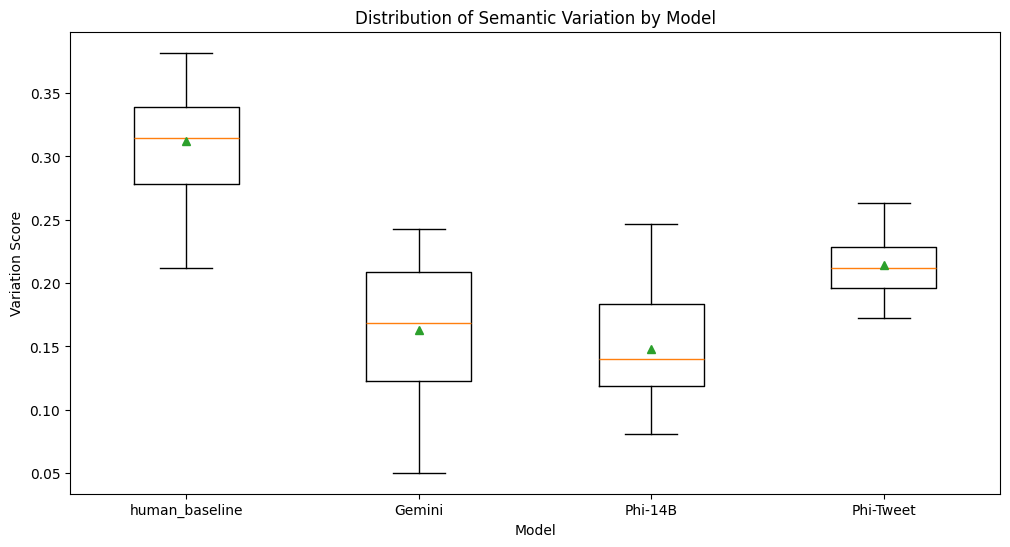

In [64]:
# Display Aggregate Results
print(pd.DataFrame(aggregate_results).T)

# Visualization: Bar Chart
plt.figure(figsize=(10, 6))
means = [aggregate_results[model]['mean_variation'] for model in models_names]
stds = [aggregate_results[model]['std_variation'] for model in models_names]
plt.bar(models_names, means, yerr=stds, capsize=5, color='skyblue', edgecolor='black')
plt.title("Tweets Semantic Variation Across Models")
plt.ylabel("Mean Variation Score")
plt.xlabel("Model")
plt.show()

# Visualization: Box Plot
all_variations = [list(scores.values()) for scores in results.values()]
plt.figure(figsize=(12, 6))
plt.boxplot(all_variations, labels=models_names, showmeans=True)
plt.title("Distribution of Semantic Variation by Model")
plt.ylabel("Variation Score")
plt.xlabel("Model")
plt.show()

### Higher Variation = Higher Creativity + More Diverse -> Human-Like Tweets

- Moderate Semantic Variation: Phi-Tweet achieves a mean variation of 0.214, closer to human-like diversity compared to other models (Gemini: 0.163, Phi-14B: 0.147), but still significantly below the human baseline (0.312).

- Consistency Across Topics: Phi-Tweet has the lowest standard deviation (0.024), indicating consistent performance across topics, though with less variation than humans.

- Room for Improvement: While Phi-Tweet outperforms Gemini and Phi-14B in diversity, it still lacks the creativity and semantic richness of human-generated tweets.

